## Neural Network models

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
complete_emg = normalised_df.iloc[:,:59]
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import random
import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import torch.optim as optim



In [2]:
# Initialise the random state
#num = random.randint(1, 500)
num = 58
torch.manual_seed(num)
print(f"The generated random seed is {num}") #347

The generated random seed is 58


### Load data

In [3]:
path = "/Users/niharawarawita/Desktop/MSc Project/Data and code/complete_dataset_3subwindows.csv"
df = pd.read_csv(path)
df.head(10)

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,subwindow_start_time,subwindow_end_time,max_ch1_Hand0,max_ch2_Hand0,max_ch3_Hand0,max_ch4_Hand0,max_ch5_Hand0,max_ch6_Hand0,max_ch7_Hand0,max_ch8_Hand0,mean_ch1_Hand0,mean_ch2_Hand0,mean_ch3_Hand0,mean_ch4_Hand0,mean_ch5_Hand0,mean_ch6_Hand0,mean_ch7_Hand0,mean_ch8_Hand0,std_ch1_Hand0,std_ch2_Hand0,std_ch3_Hand0,std_ch4_Hand0,std_ch5_Hand0,std_ch6_Hand0,std_ch7_Hand0,std_ch8_Hand0,max_ch1_Hand1,max_ch2_Hand1,max_ch3_Hand1,max_ch4_Hand1,max_ch5_Hand1,max_ch6_Hand1,max_ch7_Hand1,max_ch8_Hand1,mean_ch1_Hand1,mean_ch2_Hand1,mean_ch3_Hand1,mean_ch4_Hand1,mean_ch5_Hand1,mean_ch6_Hand1,mean_ch7_Hand1,mean_ch8_Hand1,std_ch1_Hand1,std_ch2_Hand1,std_ch3_Hand1,std_ch4_Hand1,std_ch5_Hand1,std_ch6_Hand1,std_ch7_Hand1,std_ch8_Hand1,max_Ax_Hand0,max_Ay_Hand0,max_Az_Hand0,max_Vx_Hand0,max_Vy_Hand0,max_Vz_Hand0,max_Jx_Hand0,max_Jy_Hand0,max_Jz_Hand0,mean_Ax_Hand0,mean_Ay_Hand0,mean_Az_Hand0,mean_Vx_Hand0,mean_Vy_Hand0,mean_Vz_Hand0,mean_Jx_Hand0,mean_Jy_Hand0,mean_Jz_Hand0,std_Ax_Hand0,std_Ay_Hand0,std_Az_Hand0,std_Vx_Hand0,std_Vy_Hand0,std_Vz_Hand0,std_Jx_Hand0,std_Jy_Hand0,std_Jz_Hand0,max_Ax_Hand1,max_Ay_Hand1,max_Az_Hand1,max_Vx_Hand1,max_Vy_Hand1,max_Vz_Hand1,max_Jx_Hand1,max_Jy_Hand1,max_Jz_Hand1,mean_Ax_Hand1,mean_Ay_Hand1,mean_Az_Hand1,mean_Vx_Hand1,mean_Vy_Hand1,mean_Vz_Hand1,mean_Jx_Hand1,mean_Jy_Hand1,mean_Jz_Hand1,std_Ax_Hand1,std_Ay_Hand1,std_Az_Hand1,std_Vx_Hand1,std_Vy_Hand1,std_Vz_Hand1,std_Jx_Hand1,std_Jy_Hand1,std_Jz_Hand1,max_w_Hand0,max_x_Hand0,max_y_Hand0,max_z_Hand0,max_AVx_Hand0,max_AVy_Hand0,max_AVz_Hand0,max_AAx_Hand0,max_AAy_Hand0,max_AAz_Hand0,max_AJx_Hand0,max_AJy_Hand0,max_AJz_Hand0,mean_w_Hand0,mean_x_Hand0,mean_y_Hand0,mean_z_Hand0,mean_AVx_Hand0,mean_AVy_Hand0,mean_AVz_Hand0,mean_AAx_Hand0,mean_AAy_Hand0,mean_AAz_Hand0,mean_AJx_Hand0,mean_AJy_Hand0,mean_AJz_Hand0,std_w_Hand0,std_x_Hand0,std_y_Hand0,std_z_Hand0,std_AVx_Hand0,std_AVy_Hand0,std_AVz_Hand0,std_AAx_Hand0,std_AAy_Hand0,std_AAz_Hand0,std_AJx_Hand0,std_AJy_Hand0,std_AJz_Hand0,max_w_Hand1,max_x_Hand1,max_y_Hand1,max_z_Hand1,max_AVx_Hand1,max_AVy_Hand1,max_AVz_Hand1,max_AAx_Hand1,max_AAy_Hand1,max_AAz_Hand1,max_AJx_Hand1,max_AJy_Hand1,max_AJz_Hand1,mean_w_Hand1,mean_x_Hand1,mean_y_Hand1,mean_z_Hand1,mean_AVx_Hand1,mean_AVy_Hand1,mean_AVz_Hand1,mean_AAx_Hand1,mean_AAy_Hand1,mean_AAz_Hand1,mean_AJx_Hand1,mean_AJy_Hand1,mean_AJz_Hand1,std_w_Hand1,std_x_Hand1,std_y_Hand1,std_z_Hand1,std_AVx_Hand1,std_AVy_Hand1,std_AVz_Hand1,std_AAx_Hand1,std_AAy_Hand1,std_AAz_Hand1,std_AJx_Hand1,std_AJy_Hand1,std_AJz_Hand1
0,7,14,3,smoothness,1,3,medium,2,1,2021-08-05 13:21:31.481,2021-08-05 13:21:32.468,0.504132,0.620513,0.675978,0.500000,0.759036,0.652406,0.76250,0.666667,0.497498,0.612780,0.665895,0.492285,0.718526,0.636907,0.748853,0.660720,0.002329,0.002760,0.003011,0.002201,0.006194,0.004289,0.003634,0.002595,0.508197,0.929578,0.757225,0.730159,0.497959,0.995918,0.663366,0.580645,0.497102,0.848495,0.692072,0.634859,0.491574,0.511567,0.596728,0.558018,0.003056,0.009851,0.011220,0.016046,0.002283,0.125342,0.014496,0.005100,-0.850708,-0.068771,0.490311,0.000525,0.000406,0.000903,1.269531,1.220703,2.258301,-0.863979,-0.089162,0.468123,-4.589844e-06,1.483398e-05,-1.191406e-05,-0.010928,-0.052313,0.060087,0.006994,0.008424,0.010178,0.000201,0.000180,0.000270,0.599364,0.630856,0.794158,1.023270,0.042786,-0.178879,0.001218,0.001529,0.001429,4.089355,5.468750,3.271484,0.970242,-0.011443,-0.239064,-3.020508e-05,-8.115234e-06,0.000065,0.061211,0.036287,-0.170119,0.017187,0.014988,0.034359,0.000440,0.000417,0.000641,1.262790,1.374306,1.977670,0.179352,0.488418,0.160615,-0.840857,0.133141,0.061469,0.117029,4.332320,2.887801,19.812834,554.574503,316.450316,1338.775861,0.171550,0.486515,0.155002,-0.842509,-0.002358,-0.006487,-0.037808,-0.069210,0.040128,0.213198,-18.896953,-5.997847,29.264918,0.004033,0.001122,0.003172,0.000812,0.034035,0.027288,0.100030,1.808784,1.34

In [4]:
# Remove enjoyment as we are only considering physical properties
print(df.shape)
physical_df = df[df.property_name!='enjoyment']
physical_df.shape

(1512, 191)


(1260, 191)

In [5]:
# Obtain a df of features
features_df = physical_df.iloc[:,11:]
features_df.head()


,max_ch1_Hand0,max_ch2_Hand0,max_ch3_Hand0,max_ch4_Hand0,max_ch5_Hand0,max_ch6_Hand0,max_ch7_Hand0,max_ch8_Hand0,mean_ch1_Hand0,mean_ch2_Hand0,mean_ch3_Hand0,mean_ch4_Hand0,mean_ch5_Hand0,mean_ch6_Hand0,mean_ch7_Hand0,mean_ch8_Hand0,std_ch1_Hand0,std_ch2_Hand0,std_ch3_Hand0,std_ch4_Hand0,std_ch5_Hand0,std_ch6_Hand0,std_ch7_Hand0,std_ch8_Hand0,max_ch1_Hand1,max_ch2_Hand1,max_ch3_Hand1,max_ch4_Hand1,max_ch5_Hand1,max_ch6_Hand1,max_ch7_Hand1,max_ch8_Hand1,mean_ch1_Hand1,mean_ch2_Hand1,mean_ch3_Hand1,mean_ch4_Hand1,mean_ch5_Hand1,mean_ch6_Hand1,mean_ch7_Hand1,mean_ch8_Hand1,std_ch1_Hand1,std_ch2_Hand1,std_ch3_Hand1,std_ch4_Hand1,std_ch5_Hand1,std_ch6_Hand1,std_ch7_Hand1,std_ch8_Hand1,max_Ax_Hand0,max_Ay_Hand0,max_Az_Hand0,max_Vx_Hand0,max_Vy_Hand0,max_Vz_Hand0,max_Jx_Hand0,max_Jy_Hand0,max_Jz_Hand0,mean_Ax_Hand0,mean_Ay_Hand0,mean_Az_Hand0,mean_Vx_Hand0,mean_Vy_Hand0,mean_Vz_Hand0,mean_Jx_Hand0,mean_Jy_Hand0,mean_Jz_Hand0,std_Ax_Hand0,std_Ay_Hand0,std_Az_Hand0,std_Vx_Hand0,std_Vy_Hand0,std_Vz_Hand0,std_Jx_Hand0,std_Jy_Hand0,std_Jz_Hand0,max_Ax_Hand1,max_Ay_Hand1,max_Az_Hand1,max_Vx_Hand1,max_Vy_Hand1,max_Vz_Hand1,max_Jx_Hand1,max_Jy_Hand1,max_Jz_Hand1,mean_Ax_Hand1,mean_Ay_Hand1,mean_Az_Hand1,mean_Vx_Hand1,mean_Vy_Hand1,mean_Vz_Hand1,mean_Jx_Hand1,mean_Jy_Hand1,mean_Jz_Hand1,std_Ax_Hand1,std_Ay_Hand1,std_Az_Hand1,std_Vx_Hand1,std_Vy_Hand1,std_Vz_Hand1,std_Jx_Hand1,std_Jy_Hand1,std_Jz_Hand1,max_w_Hand0,max_x_Hand0,max_y_Hand0,max_z_Hand0,max_AVx_Hand0,max_AVy_Hand0,max_AVz_Hand0,max_AAx_Hand0,max_AAy_Hand0,max_AAz_Hand0,max_AJx_Hand0,max_AJy_Hand0,max_AJz_Hand0,mean_w_Hand0,mean_x_Hand0,mean_y_Hand0,mean_z_Hand0,mean_AVx_Hand0,mean_AVy_Hand0,mean_AVz_Hand0,mean_AAx_Hand0,mean_AAy_Hand0,mean_AAz_Hand0,mean_AJx_Hand0,mean_AJy_Hand0,mean_AJz_Hand0,std_w_Hand0,std_x_Hand0,std_y_Hand0,std_z_Hand0,std_AVx_Hand0,std_AVy_Hand0,std_AVz_Hand0,std_AAx_Hand0,std_AAy_Hand0,std_AAz_Hand0,std_AJx_Hand0,std_AJy_Hand0,std_AJz_Hand0,max_w_Hand1,max_x_Hand1,max_y_Hand1,max_z_Hand1,max_AVx_Hand1,max_AVy_Hand1,max_AVz_Hand1,max_AAx_Hand1,max_AAy_Hand1,max_AAz_Hand1,max_AJx_Hand1,max_AJy_Hand1,max_AJz_Hand1,mean_w_Hand1,mean_x_Hand1,mean_y_Hand1,mean_z_Hand1,mean_AVx_Hand1,mean_AVy_Hand1,mean_AVz_Hand1,mean_AAx_Hand1,mean_AAy_Hand1,mean_AAz_Hand1,mean_AJx_Hand1,mean_AJy_Hand1,mean_AJz_Hand1,std_w_Hand1,std_x_Hand1,std_y_Hand1,std_z_Hand1,std_AVx_Hand1,std_AVy_Hand1,std_AVz_Hand1,std_AAx_Hand1,std_AAy_Hand1,std_AAz_Hand1,std_AJx_Hand1,std_AJy_Hand1,std_AJz_Hand1
0,0.504132,0.620513,0.675978,0.500000,0.759036,0.652406,0.76250,0.666667,0.497498,0.612780,0.665895,0.492285,0.718526,0.636907,0.748853,0.660720,0.002329,0.002760,0.003011,0.002201,0.006194,0.004289,0.003634,0.002595,0.508197,0.929578,0.757225,0.730159,0.497959,0.995918,0.663366,0.580645,0.497102,0.848495,0.692072,0.634859,0.491574,0.511567,0.596728,0.558018,0.003056,0.009851,0.011220,0.016046,0.002283,0.125342,0.014496,0.005100,-0.850708,-0.068771,0.490311,0.000525,0.000406,0.000903,1.269531,1.220703,2.258301,-0.863979,-0.089162,0.468123,-0.000005,1.483398e-05,-1.191406e-05,-0.010928,-0.052313,0.060087,0.006994,0.008424,0.010178,0.000201,0.000180,0.000270,0.599364,0.630856,0.794158,1.023270,0.042786,-0.178879,0.001218,0.001529,0.001429,4.089355,5.468750,3.271484,0.970242,-0.011443,-0.239064,-0.000030,-8.115234e-06,0.000065,0.061211,0.036287,-0.170119,0.017187,0.014988,0.034359,0.000440,0.000417,0.000641,1.262790,1.374306,1.977670,0.179352,0.488418,0.160615,-0.840857,0.133141,0.061469,0.117029,4.332320,2.887801,19.812834,554.574503,316.450316,1338.775861,0.171550,0.486515,0.155002,-0.842509,-0.002358,-0.006487,-0.037808,-0.069210,0.040128,0.213198,-18.896953,-5.997847,29.264918,0.004033,0.001122,0.003172,0.000812,0.034035,0.027288,0.100030,1.808784,1.349269,6.515867,214.502864,135.316892,572.754308,0.618680,-0.175326,-0.753378,-0.128901,0.215491,0.583907,0.275227,21.603607,56.450019,29.424453,2797.763022,9050.317251,2366.953044,0.602964,-0.177295,-0.766545,-0.131596,-0.011132,-0.035192,-0.000290,

### Normalise the data

In [6]:
normalised_features_df = features_df.copy()
print(normalised_features_df.shape)

(1260, 180)


In [7]:
# create scaler
scaler = MinMaxScaler(feature_range=(-1,1)) # As this is the range of the activation function - tanh

# fit scaler and apply transform
normalised_features_df[normalised_features_df.columns] = scaler.fit_transform(features_df[features_df.columns])
normalised_features_df.shape

(1260, 180)

In [8]:
df_info = physical_df.iloc[:, :11]
df_info.head()

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,subwindow_start_time,subwindow_end_time
0,7,14,3,smoothness,1,3,medium,2,1,2021-08-05 13:21:31.481,2021-08-05 13:21:32.468
1,7,14,3,smoothness,1,3,medium,2,2,2021-08-05 13:21:32.495,2021-08-05 13:21:33.464
2,7,14,3,smoothness,1,3,medium,2,3,2021-08-05 13:21:33.513,2021-08-05 13:21:46.475
3,7,14,4,thickness,2,5,medium,2,1,2021-08-05 13:22:02.060,2021-08-05 13:22:03.029
4,7,14,4,thickness,2,5,medium,2,2,2021-08-05 13:22:03.061,2021-08-05 13:22:04.047


In [9]:
normalised_df = pd.concat([df_info,normalised_features_df], axis=1)
normalised_df.shape

(1260, 191)

### Create X and y data

In [10]:
def create_X_2d(df, features_starting_idx):
    
    X_2d = df.iloc[:,features_starting_idx:].values
    
    X_tensor_2d = torch.Tensor(X_2d)    
    return X_tensor_2d



In [11]:
def create_y_train_for_2d_X(df, predicting_feature = 'property_id'):
    # CreatE an instance of a one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')

    # Perform one-hot encoding on the specified column 
    encoder_df = pd.DataFrame(encoder.fit_transform(df[[predicting_feature]]).toarray())
    
    # Convert to a numpy array
    y_train = encoder_df.to_numpy()
    
    # Convert to a tensor
    y_train_tensor = torch.Tensor(y_train)
  
    return y_train_tensor



In [12]:
def create_y_test_for_2d_X(df, predicting_feature = 'property_id'):   
    y_test = df[predicting_feature].values
    y_test = y_test - 3
    
    y_test_tensor = torch.Tensor(y_test)    
    y_test_tensor = y_test_tensor.type(torch.LongTensor)
    
    return y_test_tensor


In [13]:
def create_X_3d(df, features_starting_idx):
    dim1 = df.interaction_id.nunique()
    #num_timestamps_per_interaction = df.groupby('interaction_id')['sub_window_num'].nunique()
    dim2 = df.sub_window_num.nunique()
    dim3 = df.iloc[:,features_starting_idx:].shape[1]
        
    X = np.zeros((dim1, dim2, dim3)) 

    itr_id_lst = df.interaction_id.unique().tolist()

    for i in range(len(itr_id_lst)):
        itr_id = itr_id_lst[i]
        itr_id_df = df[df.interaction_id==itr_id]  
        
        for j in range(itr_id_df.shape[0]):
            vals_arr = itr_id_df.iloc[j,features_starting_idx:].values
            X[i,j] = vals_arr
    
    X_tensor = torch.Tensor(X)    
    return X_tensor


In [14]:
def create_y_train_for_3d_X(df, predicting_feature = 'property_id'):
    # Create a dataset with only the required columns
    df2 = df[['participant_id', 'clothes_id', 'property_id', 'rating_level_num']]

    # Remove duplicates
    df2.drop_duplicates(keep='first', inplace=True)

    # Reset the indexes
    df2.reset_index(drop=True, inplace=True) 
    
    ## Create y train
    # CreatE an instance of a one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')

    # Perform one-hot encoding on the specified column 
    encoder_df = pd.DataFrame(encoder.fit_transform(df2[[predicting_feature]]).toarray())
    
    # Convert to a numpy array
    y_train = encoder_df.to_numpy()
    
    # Convert to a tensor
    y_train = torch.Tensor(y_train)
  
    return y_train



In [15]:
def create_y_test_for_3d_X(df, predicting_feature = 'property_id'):
    # Create a dataset with only the required columns
    df2 = df[['participant_id', 'clothes_id', 'property_id', 'rating_level_num']]

    # Remove duplicates
    df2.drop_duplicates(keep='first', inplace=True)

    # Reset the indexes
    df2.reset_index(drop=True, inplace=True) 
    
    y_test = df2[predicting_feature].values
    y_test = y_test - 3
    
    y_test = torch.Tensor(y_test)    
    y_test = y_test.type(torch.LongTensor)
    
    return y_test



## Model 1 - Linear model using all 180 features

### Create the model

In [197]:
class Linear_model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(180, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 5)        
           
    def forward(self, x): #, x2
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    

In [198]:
m1 = Linear_model_1()
print(m1)

Linear_model_1(
  (fc1): Linear(in_features=180, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=5, bias=True)
)


In [199]:
def find_best_model_for_fold_1(train_dataloader, val_dataloader, learning_rate, num_epochs):

    # Model
    train_model = Linear_model_1()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1) #, train_input2
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        #print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [200]:
# Original
def Linear_LOP0CV_properties_1(data, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    macro_f1_lst = []
    acc_lst = []

    #lst = [6,24]
    
    for participant in sorted(data.participant_id.unique()): #lst: #:
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data = data[data.participant_id != participant] 
        testing_data = data[data.participant_id == participant] 

        # Data preparation
        X_train = create_X_2d(training_data, 11)       
        y_train = create_y_train_for_2d_X(training_data, predicting_feature = 'property_id')
        X_test = create_X_2d(testing_data, 11) 
        y_test = create_y_test_for_2d_X(testing_data, predicting_feature = 'property_id')

        #print(X_train.shape)
        #print(y_train.shape)
        #print(X_test.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train, y_train) 
        
        test_dataset = TensorDataset(X_test, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=90) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            #print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_fold_1(train_dataloader, val_dataloader, learning_rate, num_epochs)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = Linear_model_1()
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        macro_f1_lst.append(macro_f1_score) 
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)         
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    #if predicting_feature == 'property_id':
    print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    #elif predicting_feature == 'rating_level_num':
        #print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            



### Run the model

LEAVING PARTICIPANT 1 OUT:
The model for participant 1 has been saved
Leaving participant 1 out
(1) Confusion matrix:
 [[15  0  3  0  0]
 [13  5  0  0  0]
 [17  0  1  0  0]
 [ 7  8  2  1  0]
 [ 4  7  6  1  0]]
(2) micro F1 score = 0.24
(3) macro F1 score = 0.17
(4) Percentage Classification accuracy = 24.44%
--------------------------------
LEAVING PARTICIPANT 2 OUT:
The model for participant 2 has been saved
Leaving participant 2 out
(1) Confusion matrix:
 [[ 0  7  4  4  3]
 [ 0 14  0  0  4]
 [ 0 18  0  0  0]
 [ 0  0  1 16  1]
 [ 0 10  0  6  2]]
(2) micro F1 score = 0.36
(3) macro F1 score = 0.26
(4) Percentage Classification accuracy = 35.56%
--------------------------------
LEAVING PARTICIPANT 3 OUT:
The model for participant 3 has been saved
Leaving participant 3 out
(1) Confusion matrix:
 [[16  0  1  1  0]
 [ 2  5  3  8  0]
 [ 2  3  2 11  0]
 [ 0  0  0 18  0]
 [ 4  1  5  8  0]]
(2) micro F1 score = 0.46
(3) macro F1 score = 0.37
(4) Percentage Classification accuracy = 45.56%
----

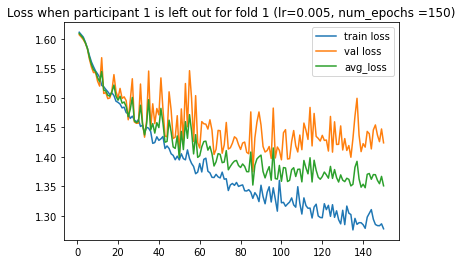

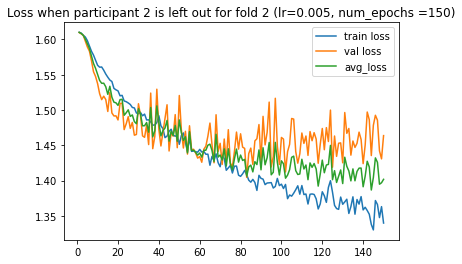

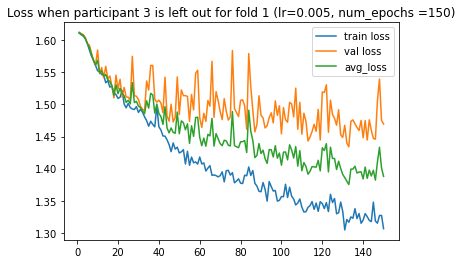

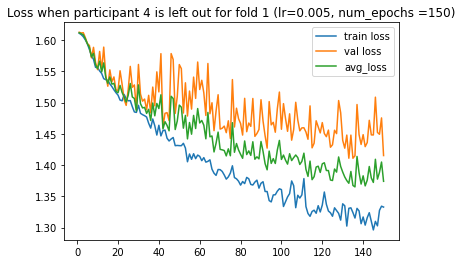

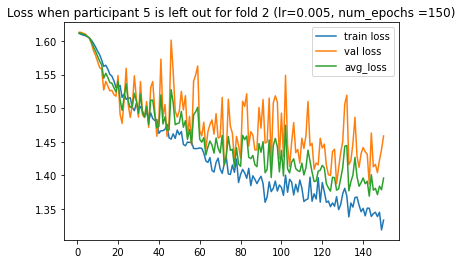

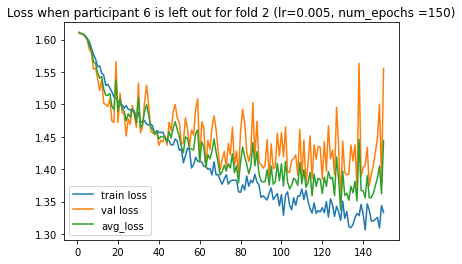

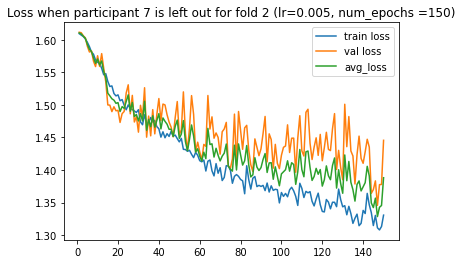

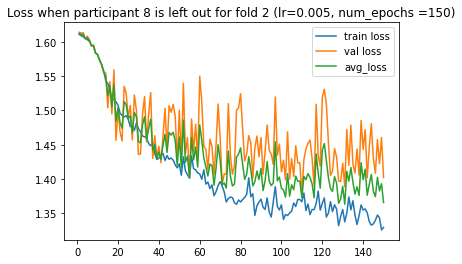

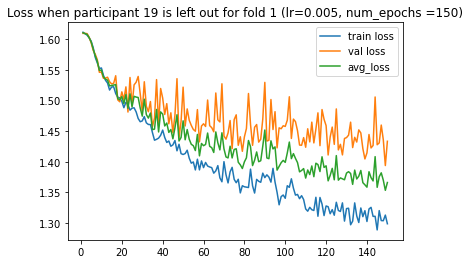

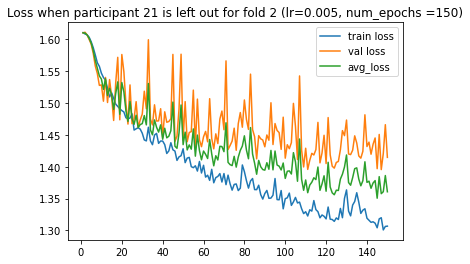

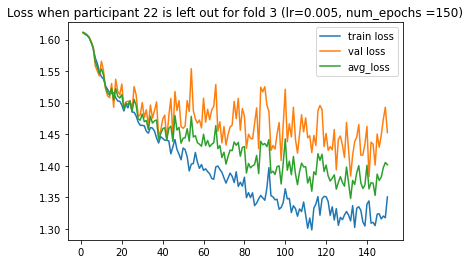

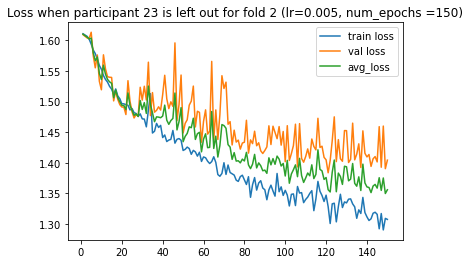

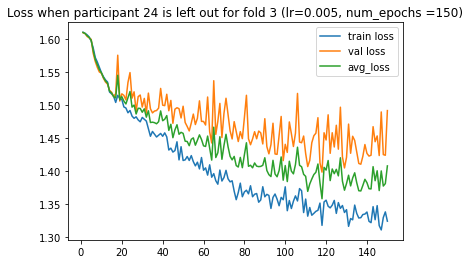

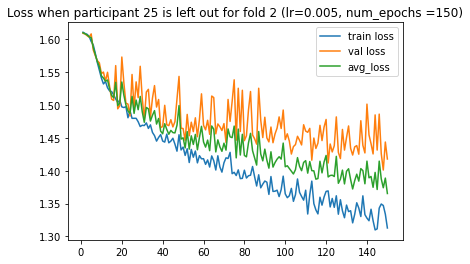

In [203]:
Linear_LOP0CV_properties_1(normalised_df, num_folds=5, predicting_feature='property_id', learning_rate=0.005, num_epochs=150, random_state=num)
    

## Model 2 - Linear model using only the emg data (48 features)

In [86]:
complete_emg = normalised_df.iloc[:,:59]

### Create the model

In [96]:
class Linear_model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(48, 25)
        self.fc2 = nn.Linear(25, 10)
        self.fc3 = nn.Linear(10, 5)        
           
    def forward(self, x): #, x2
        #print(x.shape)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    

In [97]:
m2 = Linear_model_2()
print(m2)

Linear_model_2(
  (fc1): Linear(in_features=48, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=5, bias=True)
)


In [103]:
def find_best_model_for_fold_2(train_dataloader, val_dataloader, learning_rate, num_epochs):

    # Model
    train_model = Linear_model_2()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1) #, train_input2
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        #print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [104]:
# Original
def Linear_LOP0CV_properties_2(data, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num, X_dim=2): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    macro_f1_lst = []
    acc_lst = []

    #lst = [6,24,2]#,24]
    
    for participant in sorted(data.participant_id.unique()): # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data = data[data.participant_id != participant] 
        testing_data = data[data.participant_id == participant] 

        # Data preparation
        if X_dim == 2:
            X_train = create_X_2d(training_data, 11)       
            y_train = create_y_train_for_2d_X(training_data, predicting_feature = 'property_id')
            X_test = create_X_2d(testing_data, 11) 
            y_test = create_y_test_for_2d_X(testing_data, predicting_feature = 'property_id')
        elif X_dim == 3:
            X_train = create_X_3d(training_data, 11)       
            y_train = create_y_train_for_3d_X(training_data, predicting_feature = 'property_id')
            X_test = create_X_3d(testing_data, 11) 
            y_test = create_y_test_for_3d_X(testing_data, predicting_feature = 'property_id')

        #print(X_train.shape)
        #print(y_train.shape)
        #print(X_test.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train, y_train) 
        
        test_dataset = TensorDataset(X_test, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=90) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            #print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_fold_2(train_dataloader, val_dataloader, learning_rate, num_epochs)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = Linear_model_2()
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        macro_f1_lst.append(macro_f1_score) 
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)         
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    #if predicting_feature == 'property_id':
    print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    #elif predicting_feature == 'rating_level_num':
        #print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            



### Run the model

LEAVING PARTICIPANT 1 OUT:
The model for participant 1 has been saved
Leaving participant 1 out
(1) Confusion matrix:
 [[ 8  5  5  0  0]
 [ 7  7  1  3  0]
 [16  0  2  0  0]
 [ 0  9  1  8  0]
 [ 2 10  1  5  0]]
(2) micro F1 score = 0.28
(3) macro F1 score = 0.24
(4) Percentage Classification accuracy = 27.78%
--------------------------------
LEAVING PARTICIPANT 2 OUT:
The model for participant 2 has been saved
Leaving participant 2 out
(1) Confusion matrix:
 [[ 0  5  0 13  0]
 [ 0  2  0 16  0]
 [ 0 18  0  0  0]
 [ 0  1  0 17  0]
 [ 0  4  0 14  0]]
(2) micro F1 score = 0.21
(3) macro F1 score = 0.1
(4) Percentage Classification accuracy = 21.11%
--------------------------------
LEAVING PARTICIPANT 3 OUT:
The model for participant 3 has been saved
Leaving participant 3 out
(1) Confusion matrix:
 [[17  1  0  0  0]
 [ 5  9  0  3  1]
 [10  0  2  6  0]
 [ 1  9  0  6  2]
 [ 7  9  0  1  1]]
(2) micro F1 score = 0.39
(3) macro F1 score = 0.32
(4) Percentage Classification accuracy = 38.89%
-----

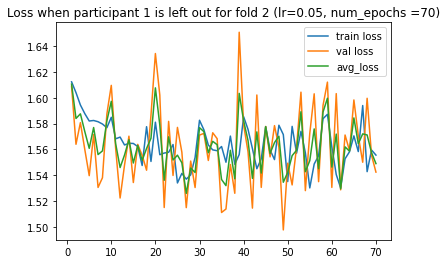

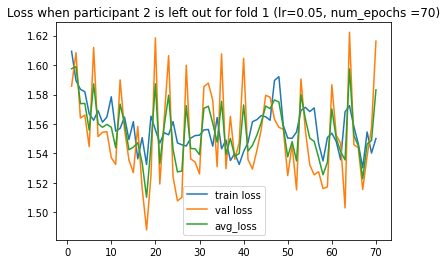

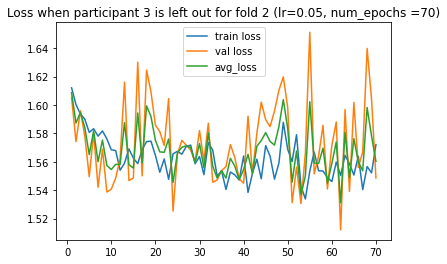

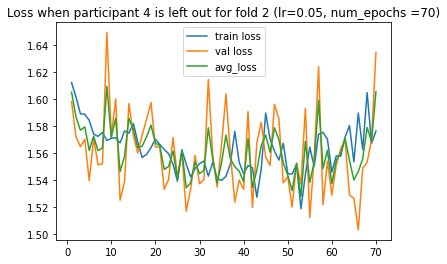

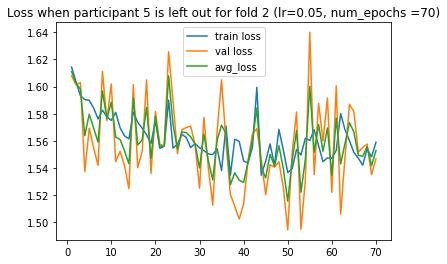

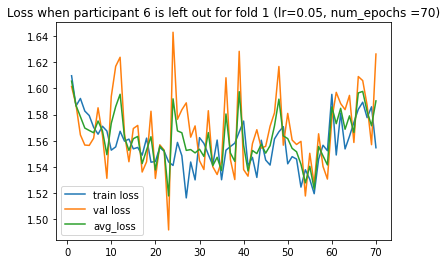

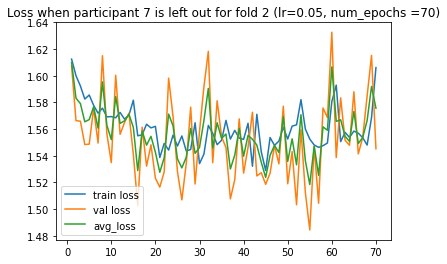

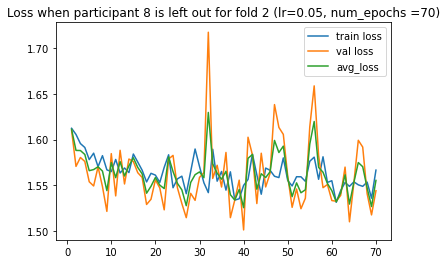

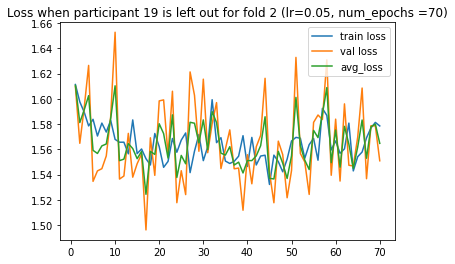

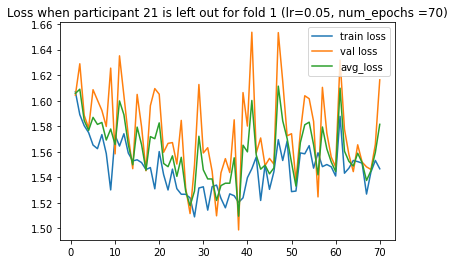

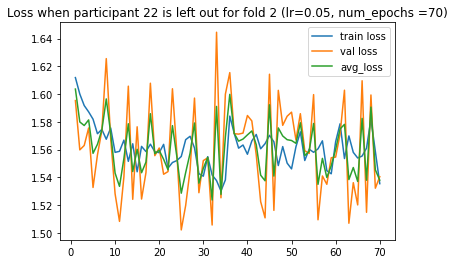

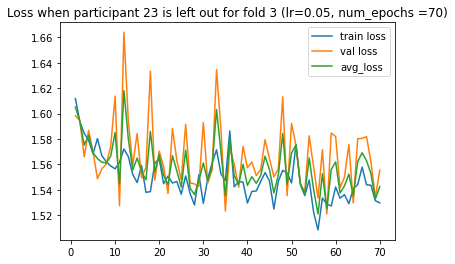

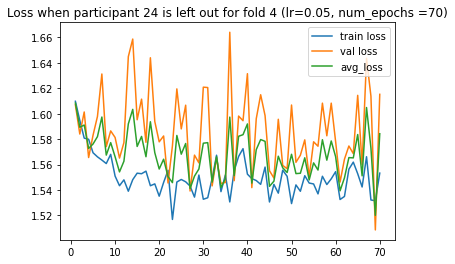

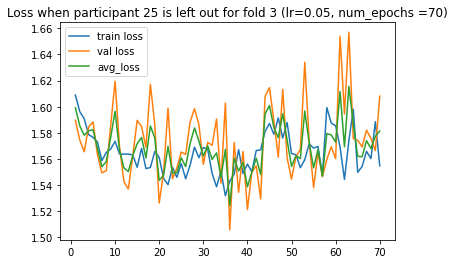

In [111]:
Linear_LOP0CV_properties_2(complete_emg, num_folds=5, predicting_feature='property_id', learning_rate=0.05, num_epochs=70, random_state=num, X_dim=2)
    

## Model 3 - LSTM + fully connected layers using all 180 features

complete_emg = normalised_df.iloc[:,:59]
hand0_emg = normalised_df.iloc[:,35:59]
hand0_emg.head()

In [244]:
# Obtain features for each hand
hand1_emg = normalised_df.iloc[:,35:59]

hand0_acc = normalised_df.iloc[:,59:86]
hand1_acc = normalised_df.iloc[:,86:113]

hand0_qua = normalised_df.iloc[:,113:152]
hand1_qua = normalised_df.iloc[:,152:]

# Combine the data to ceate a df for each hand
emg_0 = normalised_df.iloc[:,:35]
hand_0 = pd.concat([emg_0, hand0_acc, hand0_qua], axis=1)
hand_1 = pd.concat([df_info, hand1_emg, hand1_acc, hand1_qua], axis=1)

### Create the model

In [266]:
class LSTM_1(nn.Module):
    def __init__(self):
        super().__init__()
        
        #self.conv1 = nn.Conv1d(in_channels=3, out_channels=3, kernel_size=1, stride=1, padding=0, groups=3) # Change kernel size to 3
        #self.pool = nn.MaxPool1d(1, 1) # Change kernel size to 1 and stride to 1
        self.rnn = nn.LSTM(90, 40, 1, batch_first=True)
        #self.h0 = torch.randn(1, 50, 7)
        #self.c0 = torch.randn(1, 50, 7)
        self.fc1 = nn.Linear(3 * 40 * 2, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 5)
          
    def forward(self, x1, x2): #, x2
        #x1 = self.pool(F.tanh(self.conv1(x1))) # Use tanh instead?
        #x2 = self.pool(F.tanh(self.conv1(x2))) # Use tanh instead?
        
        #x = self.pool(F.relu(self.conv2(x)))
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [267]:
m3 = LSTM_1()
print(m3)

LSTM_1(
  (rnn): LSTM(90, 40, batch_first=True)
  (fc1): Linear(in_features=240, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=5, bias=True)
)


In [279]:
def find_best_model_for_fold_3(train_dataloader, val_dataloader, learning_rate, num_epochs):

    # Model
    train_model = LSTM_1()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))

            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_input2, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1, train_input2)  
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_input2, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1, val_input2) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
     
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        #print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [280]:
# Original
def LSTM_LOP0CV_properties_1(data_0, data_1, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    macro_f1_lst = []
    acc_lst = []

    #lst = [6,24,2]#,24]
    
    for participant in sorted(data_0.participant_id.unique()): # # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data_0 = data_0[data_0.participant_id != participant] 
        training_data_1 = data_1[data_1.participant_id != participant] 
        testing_data_0 = data_0[data_0.participant_id == participant] 
        testing_data_1 = data_1[data_1.participant_id == participant] 

        # Data preparation
        X_train_0 = create_X_3d(training_data_0, 11)
        X_train_1 = create_X_3d(training_data_1, 11)        
        y_train = create_y_train_for_3d_X(training_data_0, predicting_feature = 'property_id')
        X_test_0 = create_X_3d(testing_data_0, 11) 
        X_test_1 = create_X_3d(testing_data_1, 11)
        y_test = create_y_test_for_3d_X(testing_data_0, predicting_feature = 'property_id')
        #print(y_test)

        #print(X_train_0.shape)
        #print(X_train_1.shape)
        #print(y_train.shape)
        #print(X_test_0.shape)
        #print(X_test_1.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=30) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            #print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_fold_3(train_dataloader, val_dataloader, learning_rate, num_epochs)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = LSTM_1()
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_input2, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1, test_input2) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        macro_f1_lst.append(macro_f1_score) 
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)         
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    #if predicting_feature == 'property_id':
    print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    #elif predicting_feature == 'rating_level_num':
        #print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            



### Run the model

LEAVING PARTICIPANT 1 OUT:
The model for participant 1 has been saved
Leaving participant 1 out
(1) Confusion matrix:
 [[3 3 0 0 0]
 [3 2 1 0 0]
 [2 4 0 0 0]
 [2 0 4 0 0]
 [2 1 3 0 0]]
(2) micro F1 score = 0.17
(3) macro F1 score = 0.12
(4) Percentage Classification accuracy = 16.67%
--------------------------------
LEAVING PARTICIPANT 2 OUT:
The model for participant 2 has been saved
Leaving participant 2 out
(1) Confusion matrix:
 [[3 0 1 2 0]
 [2 0 2 1 1]
 [6 0 0 0 0]
 [0 0 0 6 0]
 [1 0 1 3 1]]
(2) micro F1 score = 0.33
(3) macro F1 score = 0.25
(4) Percentage Classification accuracy = 33.33%
--------------------------------
LEAVING PARTICIPANT 3 OUT:
The model for participant 3 has been saved
Leaving participant 3 out
(1) Confusion matrix:
 [[0 0 6 0 0]
 [0 0 6 0 0]
 [0 0 3 3 0]
 [0 0 3 3 0]
 [0 0 6 0 0]]
(2) micro F1 score = 0.2
(3) macro F1 score = 0.14
(4) Percentage Classification accuracy = 20.0%
--------------------------------
LEAVING PARTICIPANT 4 OUT:
The model for partici

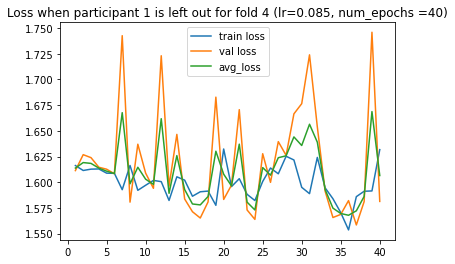

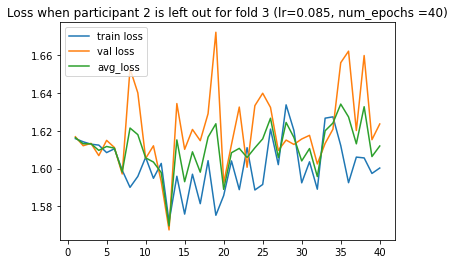

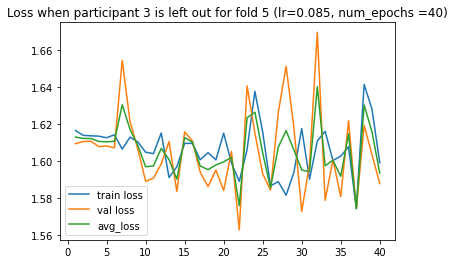

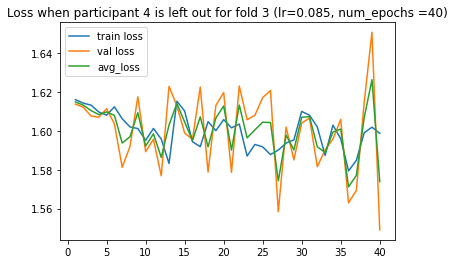

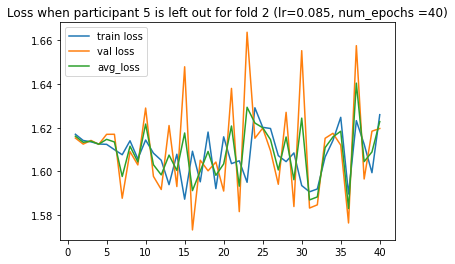

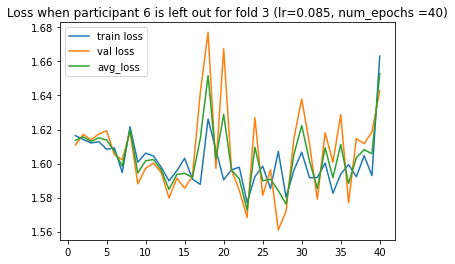

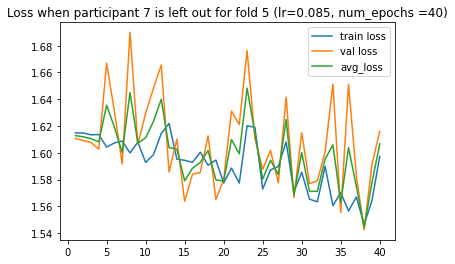

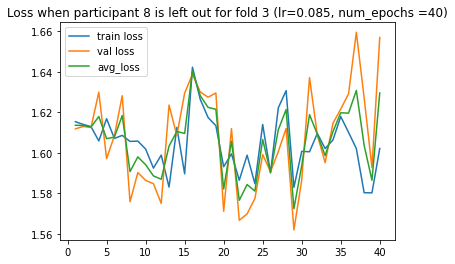

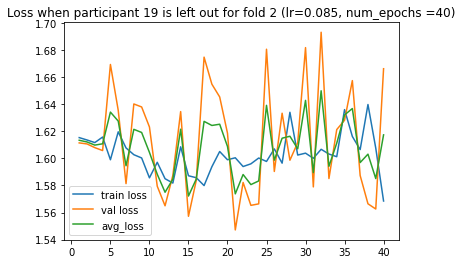

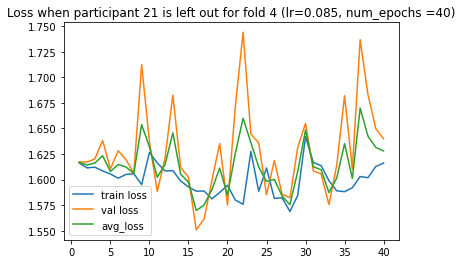

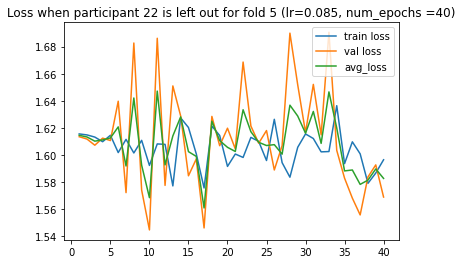

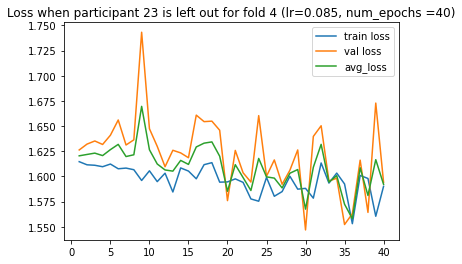

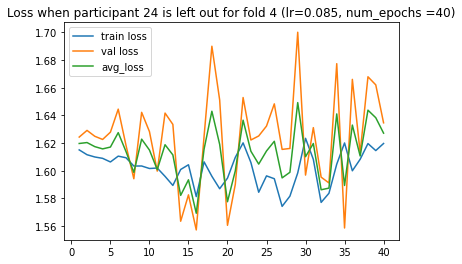

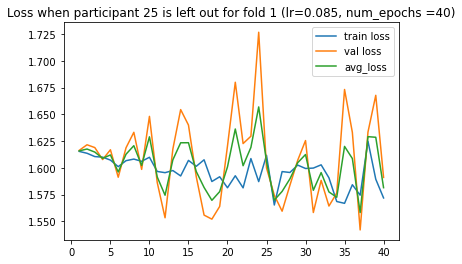

In [282]:
LSTM_LOP0CV_properties_1(hand_0, hand_1, num_folds=5, predicting_feature='property_id', learning_rate=0.085, num_epochs=40, random_state=num) 


## Model 4 - LSTM + fully connected layers using only the emg data (48 features)

complete_emg = normalised_df.iloc[:,:59]
hand0_emg = normalised_df.iloc[:,35:59]
hand0_emg.head()

In [180]:
#hand0_emg = normalised_df.iloc[:,19:27]
hand1_emg = normalised_df.iloc[:,35:59]

emg_0 = normalised_df.iloc[:,:35]
emg_1 = pd.concat([df_info, hand1_emg], axis=1)


### Create the model

In [ ]:
class LSTM_2(nn.Module):
    def __init__(self):
        super().__init__()
        
        #self.conv1 = nn.Conv1d(in_channels=3, out_channels=3, kernel_size=1, stride=1, padding=0, groups=3) # Change kernel size to 3
        #self.pool = nn.MaxPool1d(1, 1) # Change kernel size to 1 and stride to 1
        self.rnn = nn.LSTM(24, 15, 1, batch_first=True)
        #self.h0 = torch.randn(1, 50, 7)
        #self.c0 = torch.randn(1, 50, 7)
        self.fc1 = nn.Linear(3 * 15 * 2, 25)
        self.fc2 = nn.Linear(25, 10)
        self.fc3 = nn.Linear(10, 5)
          
    def forward(self, x1, x2): #, x2
        #x1 = self.pool(F.tanh(self.conv1(x1))) # Use tanh instead?
        #x2 = self.pool(F.tanh(self.conv1(x2))) # Use tanh instead?
        
        #x = self.pool(F.relu(self.conv2(x)))
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [ ]:
m4 = LSTM_2()
print(m4)

In [ ]:
def find_best_model_for_fold_4(train_dataloader, val_dataloader, learning_rate, num_epochs):

    # Model
    train_model = LSTM_2()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_input2, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1, train_input2)  
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_input2, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1, val_input2) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        #print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [ ]:
# Original
def LSTM_LOP0CV_properties_2(data_0, data_1, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    macro_f1_lst = []
    acc_lst = []

    #lst = [6,24,2]#,24]
    
    for participant in sorted(data_0.participant_id.unique()): # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data_0 = data_0[data_0.participant_id != participant] 
        training_data_1 = data_1[data_1.participant_id != participant] 
        testing_data_0 = data_0[data_0.participant_id == participant] 
        testing_data_1 = data_1[data_1.participant_id == participant] 

        # Data preparation
        X_train_0 = create_X_3d(training_data_0, 11)
        X_train_1 = create_X_3d(training_data_1, 11)        
        y_train = create_y_train_for_3d_X(training_data_0, predicting_feature = 'property_id')
        X_test_0 = create_X_3d(testing_data_0, 11) 
        X_test_1 = create_X_3d(testing_data_1, 11)
        y_test = create_y_test_for_3d_X(testing_data_0, predicting_feature = 'property_id')
        #print(y_test)

        #print(X_train_0.shape)
        #print(X_train_1.shape)
        #print(y_train.shape)
        #print(X_test_0.shape)
        #print(X_test_1.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=30) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            #print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_fold_4(train_dataloader, val_dataloader, learning_rate, num_epochs)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = LSTM_2()
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_input2, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1, test_input2) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        macro_f1_lst.append(macro_f1_score) 
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)         
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    #if predicting_feature == 'property_id':
    print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    #elif predicting_feature == 'rating_level_num':
        #print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            



### Run the model

LEAVING PARTICIPANT 1 OUT:
The model for participant 1 has been saved
Leaving participant 1 out
(1) Confusion matrix:
 [[6 0 0 0 0]
 [3 0 0 0 3]
 [6 0 0 0 0]
 [1 0 0 0 5]
 [3 0 0 0 3]]
(2) micro F1 score = 0.3
(3) macro F1 score = 0.17
(4) Percentage Classification accuracy = 30.0%
--------------------------------
LEAVING PARTICIPANT 2 OUT:
The model for participant 2 has been saved
Leaving participant 2 out
(1) Confusion matrix:
 [[0 0 2 2 2]
 [0 0 3 2 1]
 [6 0 0 0 0]
 [0 1 1 1 3]
 [0 1 1 3 1]]
(2) micro F1 score = 0.07
(3) macro F1 score = 0.06
(4) Percentage Classification accuracy = 6.67%
--------------------------------
LEAVING PARTICIPANT 3 OUT:
The model for participant 3 has been saved
Leaving participant 3 out
(1) Confusion matrix:
 [[1 5 0 0 0]
 [0 1 0 5 0]
 [3 0 1 2 0]
 [0 0 0 6 0]
 [1 1 0 4 0]]
(2) micro F1 score = 0.3
(3) macro F1 score = 0.23
(4) Percentage Classification accuracy = 30.0%
--------------------------------
LEAVING PARTICIPANT 4 OUT:
The model for participan

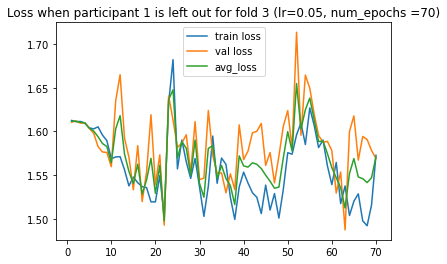

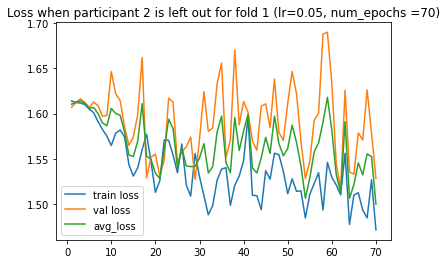

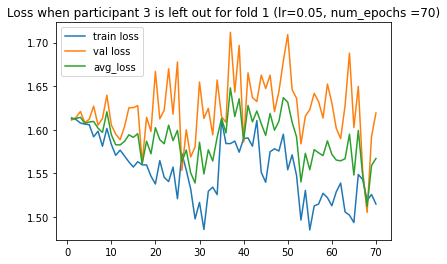

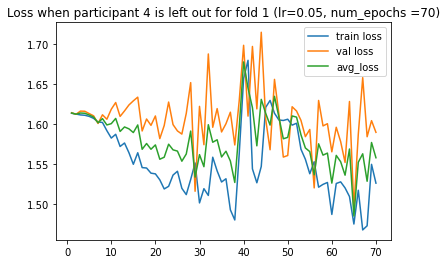

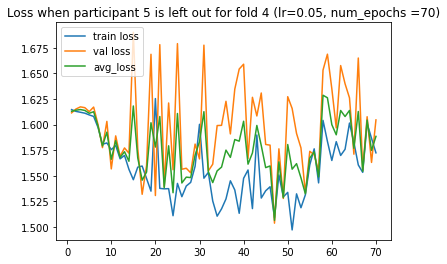

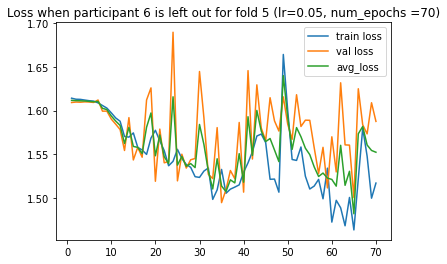

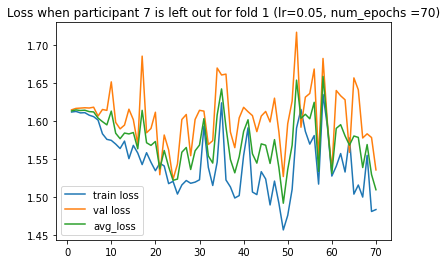

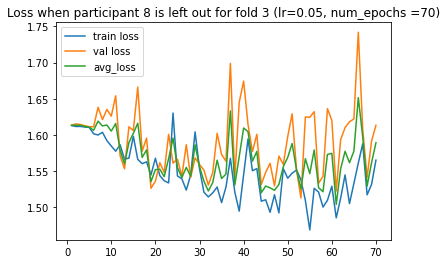

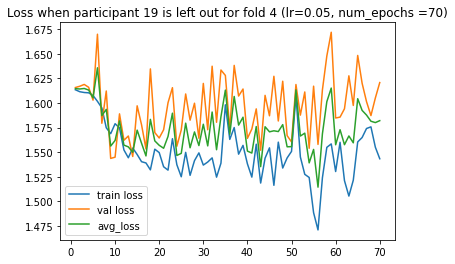

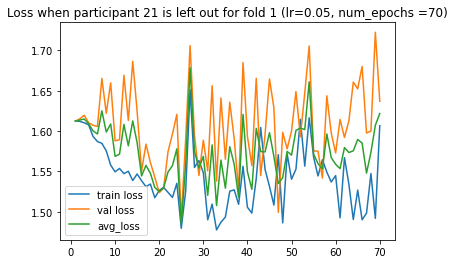

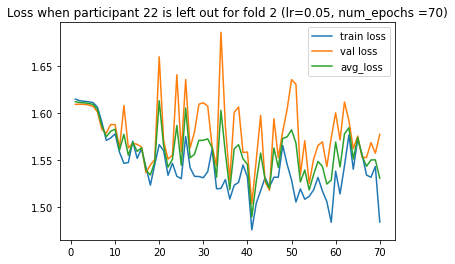

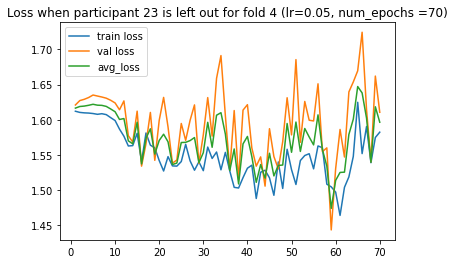

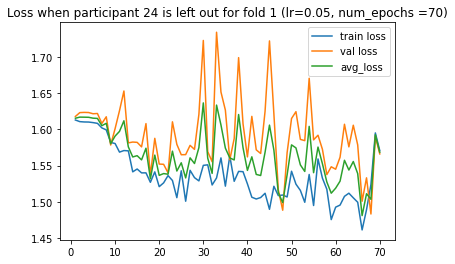

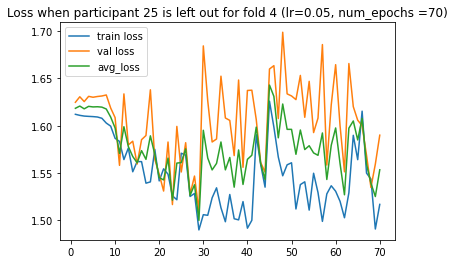

In [190]:
LSTM_LOP0CV_properties_2(emg_0, emg_1, num_folds=5, predicting_feature='property_id', learning_rate=0.05, num_epochs=70, random_state=num) 


In [ ]:
t2 = time.time()

## Model 5 - CNN + LSTM

In [117]:
complete_emg = normalised_df.iloc[:,:59]
hand0_emg = normalised_df.iloc[:,43:51]
hand0_emg.head()

,mean_ch1_Hand1,mean_ch2_Hand1,mean_ch3_Hand1,mean_ch4_Hand1,mean_ch5_Hand1,mean_ch6_Hand1,mean_ch7_Hand1,mean_ch8_Hand1
0,0.258945,0.997200,0.751344,0.701532,0.295330,0.458744,0.440816,0.298715
1,0.258478,0.998128,0.752897,0.700869,0.294375,0.405040,0.441458,0.298811
2,0.258554,0.997869,0.750619,0.699494,0.282343,0.422802,0.438818,0.298176
3,0.258337,0.997686,0.750687,0.699454,0.293985,0.407644,0.433812,0.297794
4,0.258541,0.998229,0.750420,0.698867,0.294158,0.407857,0.434614,0.298768


In [121]:
hand0_emg = normalised_df.iloc[:,19:27]
hand1_emg = normalised_df.iloc[:,43:51]

emg_0 = pd.concat([df_info, hand0_emg], axis=1)
emg_1 = pd.concat([df_info, hand1_emg], axis=1)


### Create the model

In [122]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=3, kernel_size=1, stride=1, padding=0, groups=3) # Change kernel size to 3
        self.pool = nn.MaxPool1d(1, 1) # Change kernel size to 1 and stride to 1
        self.rnn = nn.LSTM(8, 4, 1, batch_first=True)
        #self.h0 = torch.randn(1, 50, 7)
        #self.c0 = torch.randn(1, 50, 7)
        self.fc1 = nn.Linear(3 * 4 * 2, 18)
        self.fc2 = nn.Linear(18, 10)
        self.fc3 = nn.Linear(10, 5)
          
    def forward(self, x1, x2): #, x2
        x1 = self.pool(F.tanh(self.conv1(x1))) # Use tanh instead?
        x2 = self.pool(F.tanh(self.conv1(x2))) # Use tanh instead?
        
        #x = self.pool(F.relu(self.conv2(x)))
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [123]:
m3 = CNN_LSTM()
print(m3)

CNN_LSTM(
  (conv1): Conv1d(3, 3, kernel_size=(1,), stride=(1,), groups=3)
  (pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (rnn): LSTM(8, 4, batch_first=True)
  (fc1): Linear(in_features=24, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=5, bias=True)
)


In [138]:
def find_best_model_for_fold_3(train_dataloader, val_dataloader, learning_rate, num_epochs):

    # Model
    train_model = CNN_LSTM()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_input2, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1, train_input2)  
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_input2, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1, val_input2) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [139]:
# Original
def CNN_LSTM_LOP0CV_properties_1(data_0, data_1, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    macro_f1_lst = []
    acc_lst = []

    lst = [6,24,2]#,24]
    
    for participant in lst: #sorted(data0.participant_id.unique()): # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data_0 = data_0[data_0.participant_id != participant] 
        training_data_1 = data_1[data_1.participant_id != participant] 
        testing_data_0 = data_0[data_0.participant_id == participant] 
        testing_data_1 = data_1[data_1.participant_id == participant] 

        # Data preparation
        X_train_0 = create_X_3d(training_data_0, 11)
        X_train_1 = create_X_3d(training_data_1, 11)        
        y_train = create_y_train_for_3d_X(training_data_0, predicting_feature = 'property_id')
        X_test_0 = create_X_3d(testing_data_0, 11) 
        X_test_1 = create_X_3d(testing_data_1, 11)
        y_test = create_y_test_for_3d_X(testing_data_0, predicting_feature = 'property_id')
        #print(y_test)

        #print(X_train_0.shape)
        #print(X_train_1.shape)
        #print(y_train.shape)
        #print(X_test_0.shape)
        #print(X_test_1.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=30) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            #print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_fold_3(train_dataloader, val_dataloader, learning_rate, num_epochs)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = CNN_LSTM()
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_input2, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1, test_input2) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        macro_f1_lst.append(macro_f1_score) 
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)         
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    #if predicting_feature == 'property_id':
    print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    #elif predicting_feature == 'rating_level_num':
        #print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            



### Run the model

In [145]:
CNN_LSTM_LOP0CV_properties_1(emg_0, emg_1, num_folds=5, predicting_feature='property_id', learning_rate=0.3, num_epochs=30, random_state=num) 


LEAVING PARTICIPANT 6 OUT:
epoch 1: train loss = 1.63, val loss = 1.62, average loss = 1.62
epoch 2: train loss = 1.62, val loss = 1.62, average loss = 1.62
epoch 3: train loss = 1.62, val loss = 1.61, average loss = 1.62
epoch 4: train loss = 1.62, val loss = 1.62, average loss = 1.62
epoch 5: train loss = 1.62, val loss = 1.62, average loss = 1.62
epoch 6: train loss = 1.62, val loss = 1.62, average loss = 1.62
epoch 7: train loss = 1.62, val loss = 1.64, average loss = 1.63
epoch 8: train loss = 1.62, val loss = 1.61, average loss = 1.62
epoch 9: train loss = 1.62, val loss = 1.63, average loss = 1.62
epoch 10: train loss = 1.62, val loss = 1.63, average loss = 1.62
epoch 11: train loss = 1.62, val loss = 1.63, average loss = 1.62
epoch 12: train loss = 1.61, val loss = 1.61, average loss = 1.61
epoch 13: train loss = 1.62, val loss = 1.61, average loss = 1.62
epoch 14: train loss = 1.62, val loss = 1.62, average loss = 1.62
epoch 15: train loss = 1.62, val loss = 1.61, average loss

KeyboardInterrupt: 

In [ ]:
t2 = time.time()